### CaImAn toolbox wrapper functions
This is meant to demonstrate the use of the `caiman_wrapper` module as well as test other codes in development and troubleshoot analysis

In order to link caiman with our labs toolbox, we must run `pip install -e .` with caiman set as environment
______

Import some modules

In [1]:
from decode_lab_code.preprocessing.ophys.caiman_wrapper import caiman_preprocess
import matplotlib.pyplot as plt

### caiman_process - a wrapper module to support caiman analysis
Next, we will assign the object `caiman_process` to cp in order to interface with the caiman pipeline

In [2]:
# directory information
folder_name = '/Users/js0403/ophysdata/Trevor_750K2_200ms_RedGreen_depolar002'
fname_neuron = 'rec_neuron.tif'
frame_rate = 10

# if you get the Error: "Exception: A cluster is already runnning", restart the kernel
cp = caiman_preprocess(folder_name,fname_neuron,frame_rate,activate_cluster='activate')

Loading movie


100%|██████████| 1/1 [00:00<00:00,  6.38it/s]


cluster set-up


### Play back the movie
The purpose of the caiman_wrapper is to allow for easy, 1-liners to play videos and preprocess our videos
* This does not include the setting of parameters! This should be a longer process so that the experimenter can tweak what is needed

In [3]:
cp.watch_movie()

### Extract data
A 1-liner to extract our movie frames!

(514, 512, 512)


Text(0.5, 1.0, 'Example Frame')

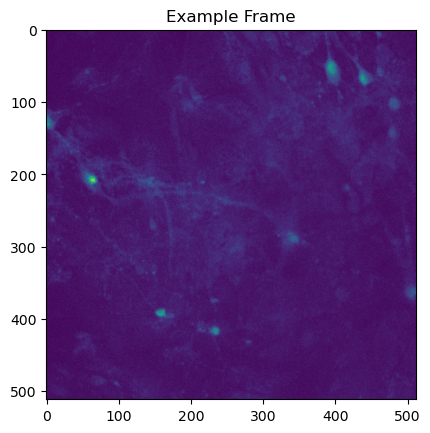

In [4]:
# here is our data
frames = cp.get_frames()

# print some stuff
print(frames.shape)
plt.imshow(frames[0,:,:])
plt.title("Example Frame")

### Back to caiman: We must pay close attention to the parameters and as such, these will not be in the wrapper
We will enter our own parameters, leaving this up for the user to adjust as needed. This is not as easy as using the wrapper

In [5]:
# lets get our attributes
cmdata = cp.get_init_vars()

['/Users/js0403/ophysdata/Trevor_750K2_200ms_RedGreen_depolar002/rec_neuron.tif']

In [11]:
# default parameters
decay_time = 0.4 # length of a typical transient in seconds

# motion correction parameters - set to false for trevor/akanksha data
# motion_correct = False   # flag for performing motion correction 
pw_rigid = False         # flag for performing piecewise-rigid motion correction (otherwise just rigid)
gSig_filt = (3, 3)       # size of high pass spatial filtering, used in 1p data
max_shifts = (5, 5)      # maximum allowed rigid shift
strides = (48, 48)     # 48 start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)      # 24 overlap between pathes (size of patch strides+overlaps)
max_deviation_rigid = 3  # maximum deviation allowed for patch with respect to rigid shifts
border_nan = 'copy'      # replicate values along the boundaries

mc_dict = {
    'fnames': cmdata['fname'],
    'fr': cmdata['frate'],
    'decay_time': decay_time,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': border_nan,
}
opts = params.CNMFParams(params_dict=mc_dict)

KeyError: 'frate'

In [7]:
# motion correct
fname_new, opts = cp.motion_correct(False)

This might take a minute...


In [8]:
fname_new

'/Users/js0403/ophysdata/Trevor_750K2_200ms_RedGreen_depolar002/memmap_d1_512_d2_512_d3_1_order_C_frames_514.mmap'

In [ ]:
import caiman as cm

# load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
images = Yr.T.reshape((T,) + dims, order='F')

# parameters for source extraction and deconvolution
p = 1               # order of the autoregressive system
K = None            # upper bound on number of components per patch, in general None
gSig = (3, 3)       # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = (13, 13)     # average diameter of a neuron, in general 4*gSig+1
Ain = None          # possibility to seed with predetermined binary masks
merge_thr = .7      # merging threshold, max correlation allowed
rf = 40             # half-size of the patches in pixels. e.g., if rf=40, patches are 80x80
stride_cnmf = 20    # amount of overlap between the patches in pixels
#                     (keep it at least large as gSiz, i.e 4 times the neuron size gSig)
tsub = 2            # downsampling factor in time for initialization,
#                     increase if you have memory problems
ssub = 1            # downsampling factor in space for initialization,
#                     increase if you have memory problems
#                     you can pass them here as boolean vectors
low_rank_background = None  # None leaves background of each patch intact,
#                     True performs global low-rank approximation if gnb>0
gnb = 0             # number of background components (rank) if positive,
#                     else exact ring model with following settings
#                         gnb= 0: Return background as b and W
#                         gnb=-1: Return full rank background B
#                         gnb<-1: Don't return background
nb_patch = 0        # number of background components (rank) per patch if gnb>0,
#                     else it is set automatically
min_corr = .8       # min peak value from correlation image
min_pnr = 10        # min peak to noise ration from PNR image
ssub_B = 2          # additional downsampling factor in space for background
ring_size_factor = 1.4  # radius of ring is gSiz*ring_size_factor

opts.change_params(params_dict={'method_init': 'corr_pnr',  # use this for 1 photon
                            'K': K,
                            'gSig': gSig,
                            'gSiz': gSiz,
                            'merge_thr': merge_thr,
                            'p': p,
                            'tsub': tsub,
                            'ssub': ssub,
                            'rf': rf,
                            'stride': stride_cnmf,
                            'only_init': True,    # set it to True to run CNMF-E
                            'nb': gnb,
                            'nb_patch': nb_patch,
                            'method_deconvolution': 'oasis',       # could use 'cvxpy' alternatively
                            'low_rank_background': low_rank_background,
                            'update_background_components': True,  # sometimes setting to False improve the results
                            'min_corr': min_corr,
                            'min_pnr': min_pnr,
                            'normalize_init': False,               # just leave as is
                            'center_psf': True,                    # leave as is for 1 photon
                            'ssub_B': ssub_B,
                            'ring_size_factor': ring_size_factor,
                            'del_duplicates': True,                # whether to remove duplicates from initialization
                            'border_pix': bord_px})                # number of pixels to not consider in the borders)
self.opts = opts

if show_summmary:
# compute some summary images (correlation and peak to noise)
cn_filter, pnr = cm.summary_images.correlation_pnr(self.images, gSig=gSig[0], swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile

# inspect the summary images and set the parameters
nb_inspect_correlation_pnr(cn_filter, pnr)